# Plotting the Pareto Front from WandB sweeps :

### Imports & Installs :

In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import parallel_backend, Parallel, delayed
import tqdm

### Get run hashes and load run-table artifacts :  

In [2]:
api = wandb.Api()
entity = "algue"
project = "ICLR_Cifar10"
states = ["finished", "killed"]  # only runs that did not failed or crashed.
sweeps = {
  'acc_eps20_certacc_0' : 'q4zk798t',
  'acc_eps20_certacc_1' : 'g1kkuykc',
  'acc_eps20_certacc_2' : 'bbidcxvf',
  'acc_eps20_certacc_4' : 'n222sidg',
  'acc_eps20_certacc_8' : 'qjpo7dh8',
  'acc_eps20_certacc_16': 'l3pr52hk',
}
sweeps_opacus = {
    'opacus_resnet': 'mf2npmbi',
    # 'opacus_mlp': 'lbhfq07e',
}
name_from_id = {v: k for k, v in sweeps.items()}
for k, v in sweeps_opacus.items():
    name_from_id[v] = k
sweep_ids = list(sweeps.values())
filters = {"state": {"$in": states}, 'sweep': {"$in": sweep_ids}}  

redownload = False
if redownload:  
  runs = api.runs(entity + "/" + project, filters) 

In [3]:
faulty_runs = {}

def get_hist(run, add_config=True):
    # requires that n_epoch < 1024 to work ! (otherwise increase sample)
    hist = run.history(samples=2048)
    # check for empty runs
    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist
    
    if "EPSILON" not in hist.columns:
      faulty_runs[run.name] = "no_epsilon"
      return hist
    
    # re-order columns and reindex data
    hist = hist.sort_values(by=["epoch", "_step"], axis=0)
    hist = hist.reset_index(drop=True)

    # backward fill the "epsilon" field (reported on epoch+1)
    hist = hist.fillna(method='bfill', limit=2)
    # hist = hist.fillna(method='ffill', limit=2)  # for mia-attacks.

    # drop row where epsilon is not known
    hist = hist.dropna(how="any", subset=["epsilon", "val_accuracy"], axis=0)

    # take one value out of two
    hist = hist.iloc[::2, :]

    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist

    hist['name'] = run.name
    hist['sweep'] = name_from_id[run.sweep.id]
    if add_config:
      for k, v in run.config.items():
        hist[k] = v
    hist['num_epochs'] = len(hist)
    hist['run_id'] = run.id
    
    return hist

if redownload:
  n_jobs = 10
  histories = []
  debug = False
  num_runs = 50 if debug else len(runs)
  with parallel_backend(backend='threading', n_jobs=n_jobs, require='sharedmem'):
    pfor = Parallel(n_jobs=n_jobs)(delayed(get_hist)(run, add_config=not debug) for run in tqdm.tqdm(runs[:num_runs]))
    for metrics_dataframe in tqdm.tqdm(pfor):
      histories.append(metrics_dataframe)
  histories = pd.concat(histories)
  histories = histories.dropna(how="any", subset=["epsilon", "val_accuracy"], axis=0)
  histories = histories.dropna(how="all", axis=1)
  histories = histories.sort_values(by=["num_epochs", "name", "epoch", "_step"], axis=0)
  faulty_runs = pd.DataFrame.from_dict(faulty_runs, orient="index", columns=["reason"])

In [4]:
def get_hist_opacus(run, add_config=True):
    # requires that EPOCHS < 1024 to work ! (otherwise increase sample)
    hist = run.history(samples=2048)
    # check for empty runs
    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist
    
    if "epsilon" not in hist.columns:
      faulty_runs[run.name] = "no_epsilon"
      return hist
    
    # re-order columns and reindex data
    hist = hist.sort_values(by=["epoch", "_step"], axis=0)
    hist = hist.reset_index(drop=True)

    # drop row where epsilon is not known
    hist = hist.dropna(how="any", subset=["epsilon", "val_accuracy"], axis=0)

    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist

    # add name to data
    hist['name'] = run.name
    hist['sweep'] = name_from_id[run.sweep.id]
    # append metadata (for instance sweep params!)
    if add_config:
      for k, v in run.config.items():
        hist[k] = v
    hist['num_epochs'] = len(hist)
    hist['run_id'] = run.id
    
    return hist

def get_opacus_runs():
  api = wandb.Api()
  entity = "algue"
  project = "ICLR_Opacus_Cifar10"
  states = ["finished", "killed", "running"]  # only runs that did not failed or crashed.
  sweep_ids = list(sweeps_opacus.values())
  filters = {"state": {"$in": states}, 'sweep': {"$in": sweep_ids}}  

  runs = api.runs(entity + "/" + project, filters) 

  histories = []
  n_jobs = 10
  debug = False
  with parallel_backend(backend='threading', n_jobs=n_jobs, require='sharedmem'):
    pfor = Parallel(n_jobs=n_jobs)(delayed(get_hist_opacus)(run, add_config=not debug) for run in tqdm.tqdm(runs))
    for metrics_dataframe in tqdm.tqdm(pfor):
      histories.append(metrics_dataframe)

  histories = pd.concat(histories)
  histories = histories.dropna(how="any", subset=["epsilon", "val_accuracy"], axis=0)
  histories = histories.dropna(how="all", axis=1)
  histories = histories.sort_values(by=["EPOCHS", "name", "epoch", "_step"], axis=0)
  return histories

opacus_hist = get_opacus_runs()
opacus_hist

100%|██████████| 20/20 [00:00<00:00, 75032.27it/s]


,_step,epsilon,accuracy,_timestamp,val_loss,val_epoch,loss,epoch,_runtime,delta,...,EPOCHS,EPSILON,sweep_id,log_wandb,BATCH_SIZE,MAX_GRAD_NORM,sweep_yaml_config,MAX_PHYSICAL_BATCH_SIZE,num_epochs,run_id
0,0,19.990826,0.098041,1.695634e+09,6.353306,1,36.156680,1,52.867483,0.00001,...,1,20,,sweep_cifar10,2000,0.129804,experiments/paper_plots/opacus_cifar10.yaml,200,1,6zf3ts8o
0,0,15.995284,0.251423,1.695636e+09,1.910835,1,2.096110,1,47.248856,0.00001,...,2,20,,sweep_cifar10,1000,0.759089,experiments/paper_plots/opacus_cifar10.yaml,200,2,rxhgpsuc
1,1,19.999911,0.346381,1.695636e+09,1.802558,2,1.828817,2,87.922384,0.00001,...,2,20,,sweep_cifar10,1000,0.759089,experiments/paper_plots/opacus_cifar10.yaml,200,2,rxhgpsuc
0,0,15.995284,0.102954,1.695637e+09,2.411215,1,3.859198,1,47.313033,0.00001,...,2,20,,sweep_cifar10,1000,2.136437,experiments/paper_plots/opacus_cifar10.yaml,200,2,crjs7cyj
1,1,19.999911,0.188909,1.695637e+09,1.911932,2,2.205820,2,87.703218,0.00001,...,2,20,,sweep_cifar10,1000,2.136437,experiments/paper_plots/opacus_cifar10.yaml,200,2,crjs7cyj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,370,19.857968,0.543862,1.695692e+09,1.902890,371,1.709858,371,22835.259901,0.00001,...,375,20,,sweep_cifar10,500,0.303976,experiments/paper_plots/opacus_cifar10.yaml,200,375,5kzoad2m
371,371,19.892148,0.536630,1.695692e+09,1.898140,372,1.743008,372,22926.907113,0.00001,...,375,20,,sweep_cifar10,500,0.303976,experiments/paper_plots/opacus_cifar10.yaml,200,375,5kzoad2m
372,372,19.926302,0.538424,1.695692e+09,1.902564,373,1.741843,373,23013.055382,0.00001,...,375,20,,sweep_cifar10,500,0.303976,experiments/paper_plots/opacus_cifar10.yaml,200,375,5kzoad2m
373,373,19.960432,0.540294,1.695692e+09,1.904188,374,1.727001,374,23098.732067,0.00001,...,375,20,,sweep_cifar10,500,0.303976,experiments/paper_plots/opacus_cifar10.yaml,200,375,5kzoad2m


In [5]:
if redownload:
  histories.to_csv("robustness_cifar10.csv", index=False)

In [6]:
histories = pd.read_csv("robustness_cifar10.csv")

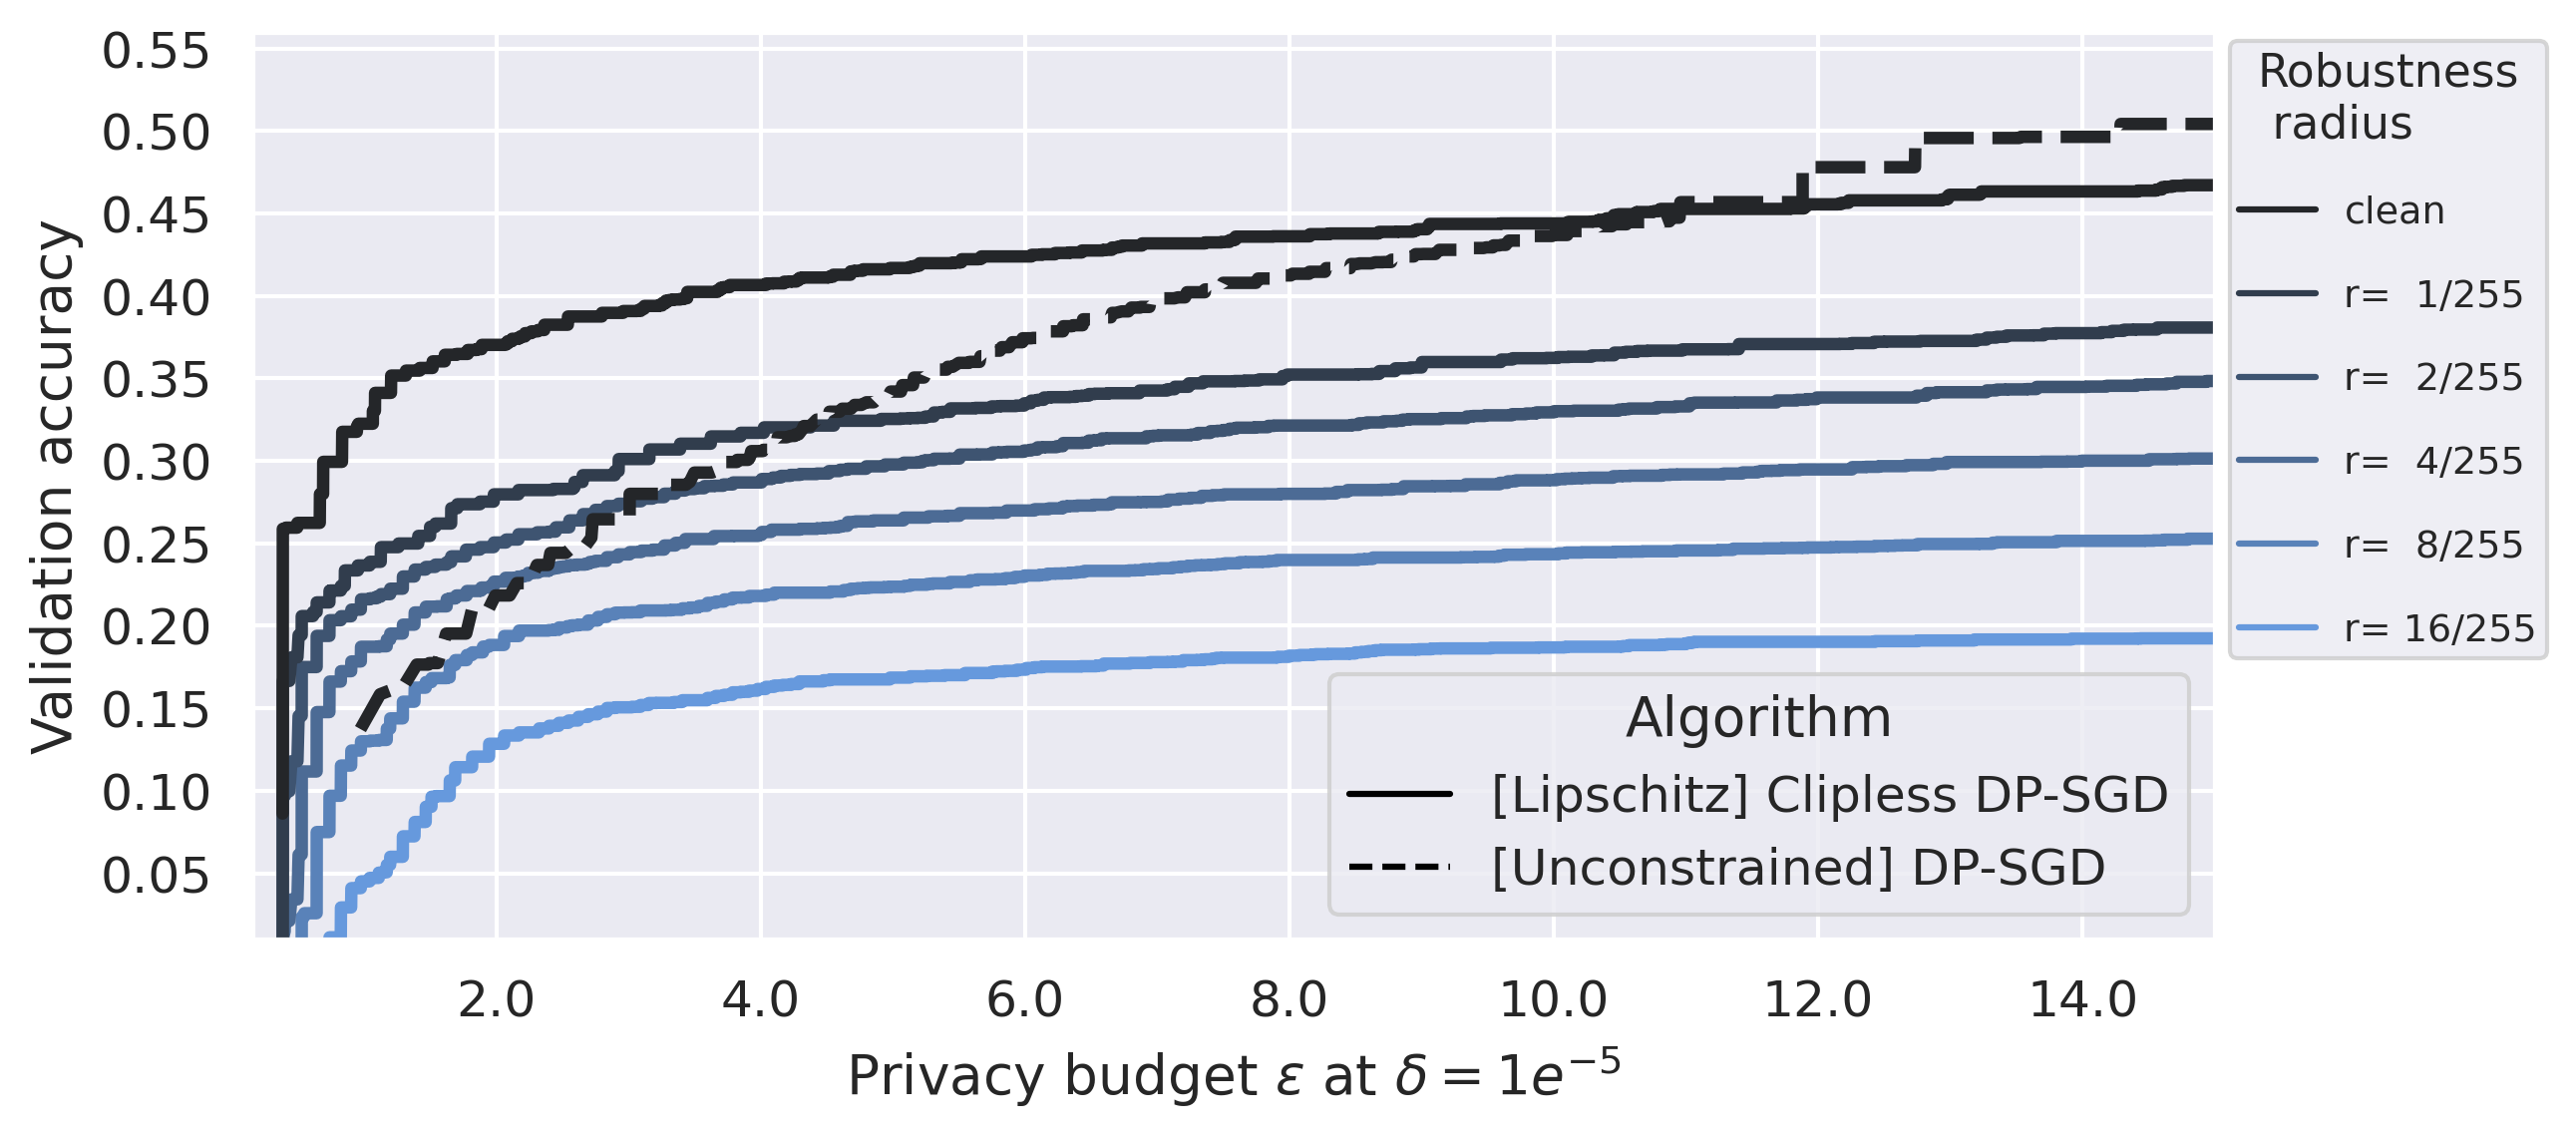

In [81]:
import seaborn as sns
import math

sns.set_context("paper")

def plot_all_datasets(use_all_sweeps=True, custom_legend=False):
  num_cols = 1
  num_rows = 1
  unit_row = 4
  unit_col = 10
  sns.set(rc={'figure.figsize':(num_cols * unit_col, num_rows * unit_row)})
  sns.set(font_scale=1.1)

  fig, ax = plt.subplots(figsize=(num_cols * unit_col, num_rows * unit_row), dpi=300)

  df = {}

  sorted_keys = sorted(sweeps.keys(), key=lambda k: int(k.split("_")[-1]), reverse=True)
  for sweep_name in sorted_keys:
    delta = 5
    radius = int(sweep_name.split("_")[-1])
    legend_label = f"r={radius:3}/255" if radius > 0 else "clean" 

    metric = f"val_certacc_{radius}" if radius > 0 else "val_accuracy"

    if use_all_sweeps:
      histories_radius = histories
    else:  
      histories_radius = histories[histories["sweep"] == sweep_name]
    pareto_front = histories_radius.set_index("epsilon").sort_values("epsilon")
    pareto_front = pareto_front[metric].expanding().max()

    df[sweep_name] = pd.DataFrame.from_dict({
      "epsilon": pareto_front.index,
      "metric": pareto_front.values,
      "Robustness radius": [legend_label] * len(pareto_front),
      "Algorithm": "[Lipschitz] Clipless DP-SGD",
    })

  pareto_front = opacus_hist.set_index("epsilon").sort_values("epsilon")
  pareto_front = pareto_front['val_accuracy'].expanding().max()
  df['opacus_resnet'] = pd.DataFrame.from_dict({
    "epsilon": pareto_front.index,
    "metric": pareto_front.values,
    "Robustness radius": ["clean"] * len(opacus_hist),
    "Algorithm": "[Unconstrained] DP-SGD",
  })  
    
  # stack of dataframes
  df = pd.concat(df.values(), ignore_index=True, axis=0)
  # palette = sns.color_palette("flare", len(sorted_keys))
  # palette = sns.color_palette("mako", len(sorted_keys))[::-1]
  palette = sns.dark_palette("#69d", len(sorted_keys), reverse=True)
  sns.lineplot(
    data=df,
    x='epsilon', y='metric',
    hue='Robustness radius',
    style='Algorithm',
    palette=palette,
    lw=3,
    errorbar=None,
    zorder=2,
    ax=ax)

  ticks = [2.0, 4.0, 6.0, 8.0, 10., 12.0, 14.0, 16.0, 20.0]
  labels = [str(v) for v in ticks]
  ax.set_xticks(ticks, labels=labels)
  ax.set(xlim=(0.15, 15.0))

  yticks = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
  ylabels = list(map(lambda v: f"{v:.2f}", yticks))
  ax.set_yticks(yticks, labels=ylabels)
  ax.set(ylim=(0.01, 0.56))

  ax.set_xlabel(f"Privacy budget $\epsilon$ at $\delta=1e^{{{-delta}}}$")
  ax.set_ylabel("Validation accuracy") 

  if custom_legend:
    handles, labels = ax.get_legend_handles_labels()

    # Create a custom legend for the "style" part
    unique_styles = ['-', '--']  # Custom marker styles
    style_handles = [plt.Line2D([0], [0], linestyle=style, markersize=5,
                                # marker='o',
                                color='black') for style in unique_styles]
    style_labels = df['Algorithm'].unique()
    style_legend = plt.legend(style_handles, style_labels, title="Algorithm", loc="lower right", bbox_to_anchor=(1.0, 0.0))

    del labels[0]  # title of "Style" legend
    del handles[0]  # handle of "Style" legend
    
    hue_labels = labels[:len(df['Robustness radius'].unique())][::-1]
    hue_handles = handles[:len(df['Robustness radius'].unique())][::-1]

    # Customize the legend for the "hue" part
    hue_legend = plt.legend(hue_handles,
                            hue_labels,
                            title='Robustness\n radius', loc="center left",
                            bbox_to_anchor=(1., 0.65),
                            labelspacing=1.25,
                            borderpad=0.25,
                            handletextpad=0.75,
                            borderaxespad=0.4,
                            fontsize='x-small',
                            title_fontsize='small'
                            )

    # Combine both legends
    ax.add_artist(style_legend)
    # ax.add_artist(hue_legend)
  else:
    # move legend in bottom right corner
    ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), ncol=3)

  plt.tight_layout()
  plt.subplots_adjust(right=0.75)  # Adjust the right margin
  plt.savefig('robustness_cifar10.png', dpi=300, bbox_inches='tight')

plot_all_datasets(custom_legend=True)

In [8]:
keys = ['val_accuracy', 
        'val_certacc_1', 
        'val_certacc_2', 
        'val_certacc_4', 
        'val_certacc_8', 
        'val_certacc_16']
radii = [0, 1, 2, 4, 8, 16]
restrict = True
for j, (i, key) in enumerate(zip(radii, keys)):
  prefix = f"r={i}"
  pos = histories[key].argmax()
  row = histories.iloc[pos]
  measures = [f'{row[key]*100:3.1f}' for key in keys]
  measures[j] = f'\\bm{{{measures[j]}}}'
  measures = [f'${n}$' for n in measures]
  measures = ' & '.join(measures)
  temp = 1 / row['tau']
  sweep_name = f'acc_eps20_certacc_{i}'
  histories_sub = histories[histories['sweep'] == sweep_name] 
  auroc = histories_sub['mia_auc_entire_dataset'].max()*100
  adv = histories_sub['mia_adv_entire_dataset'].max()*100
  print(f"$\\tau={temp:.2f}$ & {measures} & {auroc:.1f} & {adv:.1f}\\\\")

$\tau=0.01$ & $\bm{47.4}$ & $5.9$ & $0.1$ & $0.0$ & $0.0$ & $0.0$ & nan & nan\\
$\tau=0.22$ & $44.4$ & $\bm{39.1}$ & $34.2$ & $24.9$ & $11.5$ & $0.8$ & nan & nan\\
$\tau=0.40$ & $41.6$ & $38.4$ & $\bm{35.6}$ & $29.6$ & $19.1$ & $5.3$ & nan & nan\\
$\tau=0.74$ & $38.4$ & $36.4$ & $34.7$ & $\bm{30.9}$ & $24.1$ & $13.0$ & 51.9 & 20.5\\
$\tau=2.77$ & $33.3$ & $32.2$ & $31.2$ & $29.3$ & $\bm{25.9}$ & $18.8$ & 52.5 & 21.3\\
$\tau=5.40$ & $32.5$ & $31.4$ & $30.4$ & $28.8$ & $25.5$ & $\bm{19.7}$ & 59.7 & 23.6\\
